In [96]:
import creatingFeatures as cf
import re
import math
import pandas as pd
import numpy as np
from tqdm import tqdm

In [97]:
fileNames = ["TR_neg_SPIDER", "TR_pos_SPIDER", "TS_neg_SPIDER", "TS_pos_SPIDER"]
featureNames = "AAC,DPC,CTD,PAAC,APAAC,RSacid,RSpolar,RSsecond,RScharge,RSDHP".split(',')
labels = ['Negative', 'Positive']
RANDOM_SEED = 42

In [98]:
# Load scikit's classifier libraries
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [99]:
def read_fasta(file):
    line1 = open("./data/" + file + ".txt").read().split('>')[1:]
    line2 = [item.split('\n')[0:-1] for item in line1]
    fasta = [[item[0], re.sub('[^ACDEFGHIKLMNPQRSTVWY]', '', ''.join(item[1:]).upper())] for item in line2]
    return fasta


def createFeatureVectors(fasta, sign):
    feat = cf.Features()

    feat_AAC = feat.AAC(fasta)[0]
    feat_DPC = feat.DPC(fasta, 0)[0]
    feat_CTD = np.hstack((feat.CTDC(fasta)[0], feat.CTDD(fasta)[0], feat.CTDT(fasta)[0]))
    feat_PAAC = feat.PAAC(fasta, 1)[0]
    feat_APAAC = feat.APAAC(fasta, 1)[0]
    feat_RSacid = feat.reducedACID(fasta)
    feat_RSpolar = feat.reducedPOLAR(fasta)
    feat_RSsecond = feat.reducedSECOND(fasta)
    feat_RScharge = feat.reducedCHARGE(fasta)
    feat_RSDHP = feat.reducedDHP(fasta)

    feat_list = [feat_AAC,
                 feat_DPC,
                 feat_CTD,
                 feat_PAAC,
                 feat_APAAC,
                 feat_RSacid,
                 feat_RSpolar,
                 feat_RSsecond,
                 feat_RScharge,
                 feat_RSDHP]

    # print([len(item[0]) for item in feat_list])

    df_main = pd.DataFrame()
    for i, item in tqdm(enumerate(feat_list)):
        df = pd.DataFrame(item, columns=[f"{featureNames[i]}_{id}" for id in range(1, len(item[0]) + 1)])
        df_main = pd.concat([df_main, df], axis=1)

    df_main["TARGET"] = 1 if sign == "+" else 0

    return df_main


def createDataset(dataframes):
    df_final = pd.DataFrame()
    for df in dataframes:
        df_final = pd.concat([df_final, df], axis=0, ignore_index=True)

    return df_final


def scaleAllFeatures(feature_vecs):
    scaler = MinMaxScaler()
    scaler.fit_transform(feature_vecs)

    return scaler

In [100]:
def initializeModels():
    ET_clf = ExtraTreesClassifier(random_state=RANDOM_SEED)
    SVM_clf = SVC(random_state=RANDOM_SEED, probability=True)
    RF_clf = RandomForestClassifier(random_state=RANDOM_SEED)
    LR_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)

    return [RF_clf, SVM_clf, LR_reg, ET_clf]


def cv(clf, X, y, nr_fold):
    ix = []
    for i in range(0, len(y)):
        ix.append(i)
    ix = np.array(ix)

    allACC = []
    allSENS = []
    allSPEC = []
    allMCC = []
    allAUC = []

    for j in range(0, nr_fold):
        train_ix = ((ix % nr_fold) != j)
        test_ix = ((ix % nr_fold) == j)
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        clf.fit(train_X, train_y)
        p = clf.predict(test_X)
        pr = clf.predict_proba(test_X)[:, 1]
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        test_y = np.array(test_y)
        for i in range(0, len(test_y)):
            if test_y[i] == 0 and p[i] == 0:
                TP += 1
            elif test_y[i] == 0 and p[i] == 1:
                FN += 1
            elif test_y[i] == 1 and p[i] == 0:
                FP += 1
            elif test_y[i] == 1 and p[i] == 1:
                TN += 1
        ACC = (TP + TN) / (TP + FP + TN + FN)
        SENS = TP / (TP + FN)
        SPEC = TN / (TN + FP)
        det = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        if (det == 0):
            MCC = 0
        else:
            MCC = ((TP * TN) - (FP * FN)) / det
        AUC = roc_auc_score(test_y, pr)
        allACC.append(ACC)
        allSENS.append(SENS)
        allSPEC.append(SPEC)
        allMCC.append(MCC)
        allAUC.append(AUC)

    return np.mean(allACC), np.mean(allSENS), np.mean(allSPEC), np.mean(allMCC), np.mean(allAUC)


def trainWithSigleFeature(df, feature):
    train_X = df.drop("TARGET", axis=1)[[col for col in df.columns if col.startswith(feature)]]
    train_y = df["TARGET"]

    RF_clf, SVM_clf, LR_reg, ET_clf = initializeModels()

    RF_clf.fit(train_X, train_y)
    SVM_clf.fit(train_X, train_y)
    LR_reg.fit(train_X, train_y)
    ET_clf.fit(train_X, train_y)

    return RF_clf, SVM_clf, LR_reg, ET_clf


def testWithSingleFeature(clf, df, feature):
    test_X = df.drop("TARGET", axis=1)[[col for col in df.columns if col.startswith(feature)]]
    test_y = df["TARGET"]

    p = clf.predict(test_X)
    pr = clf.predict_proba(test_X)[:, 1]
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(0, len(test_y)):
        if test_y[i] == 0 and p[i] == 0:
            TP += 1
        elif test_y[i] == 0 and p[i] == 1:
            FN += 1
        elif test_y[i] == 1 and p[i] == 0:
            FP += 1
        elif test_y[i] == 1 and p[i] == 1:
            TN += 1
    ACC = (TP + TN) / (TP + FP + TN + FN)
    SENS = TP / (TP + FN)
    SPEC = TN / (TN + FP)
    det = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    if (det == 0):
        MCC = 0
    else:
        MCC = ((TP * TN) - (FP * FN)) / det

    AUC = roc_auc_score(test_y, pr)

    return ACC, SENS, SPEC, MCC, AUC

In [101]:
# Read the Each FASTA Files
fs_tr_neg, fs_tr_pos, fs_ts_neg, fs_ts_pos = [read_fasta(file) for file in fileNames]

df_train = createDataset([createFeatureVectors(fs_tr_neg, "-"), createFeatureVectors(fs_tr_pos, "+")])
df_test = createDataset([createFeatureVectors(fs_ts_neg, "-"), createFeatureVectors(fs_ts_pos, "+")])

10it [00:00, 343.90it/s]
10it [00:00, 400.01it/s]
10it [00:00, 1404.23it/s]
10it [00:00, 1667.38it/s]


In [102]:
df_train

,AAC_1,AAC_2,AAC_3,AAC_4,AAC_5,AAC_6,AAC_7,AAC_8,AAC_9,AAC_10,...,RSDHP_32,RSDHP_33,RSDHP_34,RSDHP_35,RSDHP_36,RSDHP_37,RSDHP_38,RSDHP_39,RSDHP_40,TARGET
0,0.000000,0.098039,0.000000,0.039216,0.058824,0.019608,0.000000,0.039216,0.078431,0.078431,...,0.083333,0.444444,0.333333,0.111111,0.000000,0.000000,0.666667,0.000000,0.000000,0
1,0.042105,0.026316,0.042105,0.036842,0.152632,0.057895,0.021053,0.052632,0.021053,0.147368,...,0.100000,0.555556,0.277778,0.055556,0.055556,0.500000,0.125000,0.187500,0.125000,0
2,0.089783,0.037152,0.034056,0.040248,0.027864,0.083591,0.012384,0.037152,0.034056,0.117647,...,0.075000,0.358974,0.282051,0.230769,0.102564,0.440000,0.320000,0.040000,0.160000,0
3,0.000000,0.024390,0.024390,0.073171,0.000000,0.170732,0.024390,0.024390,0.000000,0.024390,...,0.117647,0.444444,0.333333,0.111111,0.000000,0.200000,0.600000,0.000000,0.000000,0
4,0.017544,0.035088,0.052632,0.052632,0.000000,0.070175,0.035088,0.052632,0.035088,0.157895,...,0.055556,0.500000,0.300000,0.100000,0.000000,0.285714,0.142857,0.142857,0.285714,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,0.048465,0.009693,0.066236,0.059774,0.033926,0.061389,0.029079,0.050081,0.059774,0.092084,...,0.118483,0.373737,0.313131,0.202020,0.090909,0.392405,0.367089,0.139241,0.088608,1
2538,0.061350,0.020450,0.050613,0.060838,0.069018,0.055726,0.015337,0.069530,0.051125,0.105828,...,0.108197,0.404545,0.368182,0.163636,0.059091,0.383562,0.324201,0.095890,0.191781,1
2539,0.101732,0.021645,0.050866,0.096320,0.041126,0.051948,0.027056,0.028139,0.041126,0.106061,...,0.118321,0.393103,0.275862,0.165517,0.158621,0.416058,0.299270,0.124088,0.153285,1
2540,0.083333,0.020833,0.069444,0.059028,0.027778,0.079861,0.027778,0.079861,0.090278,0.052083,...,0.155556,0.361702,0.340426,0.106383,0.170213,0.315789,0.368421,0.157895,0.105263,1


In [103]:
df_test

,AAC_1,AAC_2,AAC_3,AAC_4,AAC_5,AAC_6,AAC_7,AAC_8,AAC_9,AAC_10,...,RSDHP_32,RSDHP_33,RSDHP_34,RSDHP_35,RSDHP_36,RSDHP_37,RSDHP_38,RSDHP_39,RSDHP_40,TARGET
0,0.089337,0.000000,0.011527,0.046110,0.005764,0.106628,0.014409,0.066282,0.025937,0.043228,...,0.024691,0.321429,0.142857,0.357143,0.142857,0.285714,0.380952,0.095238,0.190476,0
1,0.062874,0.023952,0.029940,0.026946,0.062874,0.059880,0.014970,0.038922,0.095808,0.047904,...,0.074627,0.280000,0.440000,0.240000,0.020000,0.350000,0.350000,0.200000,0.050000,0
2,0.068493,0.102740,0.051370,0.065068,0.041096,0.047945,0.020548,0.041096,0.065068,0.102740,...,0.069307,0.351351,0.432432,0.108108,0.081081,0.371429,0.285714,0.085714,0.228571,0
3,0.081897,0.019397,0.056034,0.077586,0.034483,0.079741,0.030172,0.023707,0.038793,0.125000,...,0.114286,0.373134,0.313433,0.194030,0.104478,0.412698,0.301587,0.079365,0.190476,0
4,0.109630,0.035556,0.032593,0.057778,0.029630,0.066667,0.020741,0.023704,0.056296,0.084444,...,0.085837,0.394231,0.336538,0.192308,0.067308,0.419355,0.403226,0.064516,0.096774,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,0.068627,0.026144,0.045752,0.055556,0.045752,0.075163,0.026144,0.055556,0.055556,0.111111,...,0.128713,0.388889,0.305556,0.138889,0.138889,0.375000,0.343750,0.156250,0.093750,1
457,0.088496,0.013274,0.042035,0.084071,0.024336,0.090708,0.033186,0.050885,0.066372,0.119469,...,0.099174,0.369863,0.369863,0.123288,0.123288,0.379310,0.258621,0.189655,0.155172,1
458,0.068834,0.036329,0.049713,0.072658,0.045889,0.051625,0.026769,0.061185,0.061185,0.076482,...,0.088542,0.364865,0.364865,0.135135,0.121622,0.461538,0.292308,0.123077,0.107692,1
459,0.069194,0.028436,0.053081,0.058768,0.037915,0.073934,0.015166,0.061611,0.046445,0.065403,...,0.096939,0.362205,0.346457,0.157480,0.125984,0.428571,0.369748,0.084034,0.109244,1


In [104]:
# Scale the values in all Features
scaler = scaleAllFeatures(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

In [105]:
# Cross Validate the Each Models
cv_scores = []
for feature in tqdm(featureNames):
    clfs = initializeModels()
    X = df_train_scaled.drop("TARGET", axis=1)[[col for col in df_train_scaled.columns if col.startswith(feature)]]
    y = df_train_scaled["TARGET"]
    for i, clf_str in tqdm(enumerate(["RF", "SVC", "LR", "ET"])):
        score = list(cv(clfs[i], X, y, 5))
        score.append(f"{clf_str}_{feature}")
        cv_scores.append(score)

4it [00:06,  1.66s/it][00:00<?, ?it/s]
4it [00:22,  5.58s/it][00:06<01:00,  6.67s/it]
4it [00:25,  6.34s/it][00:29<02:07, 15.89s/it]
4it [00:06,  1.73s/it][00:54<02:21, 20.23s/it]
4it [00:06,  1.72s/it][01:01<01:29, 14.98s/it]
4it [00:06,  1.71s/it][01:08<01:00, 12.06s/it]
4it [00:08,  2.08s/it][01:15<00:41, 10.30s/it]
4it [00:07,  1.94s/it][01:23<00:28,  9.65s/it]
4it [00:07,  1.89s/it][01:31<00:18,  9.06s/it]
4it [00:07,  1.93s/it][01:38<00:08,  8.60s/it]
100%|██████████| 10/10 [01:46<00:00, 10.65s/it]


In [106]:
df_cv_score = pd.DataFrame(cv_scores, columns=["ACC", "SENS", "SPEC", "MCC", "AUC", "MODEL-FEATURE"])
df_cv_score

,ACC,SENS,SPEC,MCC,AUC,MODEL-FEATURE
0,0.883166,0.907507,0.856902,0.766412,0.942976,RF_AAC
1,0.889069,0.898421,0.878973,0.778046,0.954994,SVC_AAC
2,0.851299,0.845345,0.857705,0.702797,0.924112,LR_AAC
3,0.881203,0.891592,0.870003,0.762117,0.938299,ET_AAC
4,0.848157,0.868095,0.826658,0.695953,0.925437,RF_DPC
5,0.892221,0.903736,0.879819,0.784207,0.953784,SVC_DPC
6,0.865074,0.859753,0.870793,0.730464,0.938886,LR_DPC
7,0.852089,0.855199,0.848759,0.704026,0.921153,ET_DPC
8,0.831627,0.848375,0.813583,0.663233,0.906659,RF_CTD
9,0.811174,0.758158,0.868344,0.628572,0.914227,SVC_CTD


In [ ]:

import matplotlib.pyplot as plt
# Get current axis
fig, ax = plt.subplots(1, 1, figsize=(20,10))
# line plot for ACC marks
df_cv_score.plot(kind='line',
        x='MODEL-FEATURE',
        y='ACC',ax=ax, markerfacecolor='red', markersize=2, marker='o')
 
#  line plot for SENS marks
df_cv_score.plot(kind='line', 
        x='MODEL-FEATURE',
        y='F1',
        ax=ax, markerfacecolor='blue', markersize=2, color='skyblue', marker='o')
 
 #  line plot for SENS marks
df_cv_score.plot(kind='line', 
        x='MODEL-FEATURE',
        y='AUC',
        ax=ax, markerfacecolor='red', markersize=2, color='red', marker='o')

plt.xticks(np.arange(len(df_cv_score["MODEL-FEATURE"])), df_cv_score["MODEL-FEATURE"].values)
plt.ylabel("values")
# set the title
plt.title('Cross Validation Score')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# show the plot
plt.show()

In [ ]:
testScore = []
clfs_names = ["RF", "SVC", "LR", "ET"]
for feature in featureNames:
    clfs = (RF_clf, SVM_clf, LR_reg, ET_clf) = trainWithSigleFeature(df_train_scaled, feature)
    for idx, clf in enumerate(clfs):
        testAns = (list(testWithSingleFeature(clf, df_test_scaled, feature)))
        testAns.insert(0, (f"{str(clfs_names[idx])}_{feature}"))
        testScore.append(testAns)


In [ ]:
df_test_score = pd.DataFrame(testScore, columns=["MODEL-FEATURE", "ACC", "SENS", "SPEC", "MCC", "AUC","F1"])
df_test_score

In [ ]:
def plotColumnBar(df , sortWith : str):
    df = df.sort_values([sortWith], ascending=False)
    # Figure Size
    fig, ax = plt.subplots(figsize =(10, 8))
        # Define colors based on prefix
    colors = []
    for name in df["MODEL-FEATURE"]:
        if name.startswith('LR'):
            colors.append('#C94845')
        elif name.startswith('RF'):
            colors.append('#4958B5')
        elif name.startswith('SVC'):
            colors.append('#49D845')
        elif name.startswith('ET'):
            colors.append('#777777')
    # Horizontal Bar Plot
    ax.barh(df["MODEL-FEATURE"], df[sortWith], color = colors)
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.01, i.get_y()+0.5,
                str(round((i.get_width()), 3)),
                fontsize = 8, fontweight ='bold',
                color ='grey')
    plt.xlabel("Values")
    # Add Plot Title
    ax.set_title('Test Result for ' + sortWith)
    # show plot
    plt.show()

In [ ]:
plotColumnBar(df_test_score, "ACC")
plotColumnBar(df_test_score, "SENS")
plotColumnBar(df_test_score, "SPEC")
plotColumnBar(df_test_score, "AUC")
plotColumnBar(df_test_score, "F1")

In [107]:
df_final_scores = pd.DataFrame()
for feature in featureNames:
    df = df_test_score[[val.endswith(f'_{feature}') for val in df_test_score["MODEL-FEATURE"].values]].sort_values(["AUC"], ascending=False).head(1)
    df_final_scores = pd.concat([df_final_scores, df], axis=0, ignore_index=True)
    
df_final_scores = df_final_scores.sort_values(["AUC"], ascending=False).head()
df_final_scores

,ACC,SENS,SPEC,MCC,AUC,MODEL-FEATURE
6,0.894182,0.910540,0.876531,0.788150,0.959260,SVC_RSpolar
9,0.893789,0.908261,0.878163,0.787393,0.958304,SVC_RSDHP
1,0.892221,0.903736,0.879819,0.784207,0.953784,SVC_DPC
0,0.889069,0.898421,0.878973,0.778046,0.954994,SVC_AAC
8,0.886705,0.915091,0.856086,0.773767,0.945135,RF_RScharge
7,0.886711,0.893113,0.879783,0.773268,0.955986,SVC_RSsecond
5,0.886704,0.900680,0.871609,0.773144,0.939885,ET_RSacid
4,0.876873,0.894616,0.857738,0.753456,0.942204,RF_APAAC
3,0.876476,0.893095,0.858548,0.752665,0.943964,RF_PAAC
2,0.842244,0.831677,0.853627,0.685010,0.933862,LR_CTD


In [ ]:
# create data
x = np.arange(6)
width = 0.15

# plot grouped bar chart
# plot data in grouped manner of bar type
plt.bar(x-0.3, df_final_scores.iloc[0,1:].tolist(), width, color='cyan')
plt.bar(x-0.15, df_final_scores.iloc[1,1:].tolist(), width, color='orange')
plt.bar(x, df_final_scores.iloc[2,1:].tolist(), width, color='#52f799')
plt.bar(x+0.15, df_final_scores.iloc[3,1:].tolist(), width, color='#f57889')
plt.bar(x+0.3, df_final_scores.iloc[4,1:].tolist(), width, color='#f7cb52')
plt.xticks(x, ['ACC', 'SENS', 'SPEC', 'MCC','AUC', 'F1'])
# Adding Xticks
plt.xlabel('Measures', fontweight ='bold', fontsize = 11)
plt.ylabel('Values', fontweight ='bold', fontsize = 11)
 
plt.legend(list(df_final_scores["MODEL-FEATURE"]), loc='upper center', bbox_to_anchor=(1.2, 1),
          fancybox=True)
plt.show()


In [108]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [109]:
kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

In [110]:
def SVC_objective(trial:Trial, X_train, y_train):    
    C = trial.suggest_int('C', 1, 10)
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf'])
    degree =trial.suggest_int("degree", 1, 5)
    gamma = trial.suggest_categorical("gamma", ["scale","auto"])
    max_iter = trial.suggest_int("max_iter", -1, 100)

    svc= SVC(
        kernel=kernel,
        C=C, degree = degree,
        gamma= gamma,
        probability = True,
        max_iter=max_iter,
        random_state=RANDOM_SEED
    )

    scores = cross_val_score(svc, X_train, y_train, cv=kfolds, scoring="accuracy")

    return scores.mean()

def RF_objective(trial:Trial, X_train, y_train):
    _n_estimators = trial.suggest_int("n_estimators", 25, 250)
    _max_depth = trial.suggest_int("max_depth", 5, 20)
    _criterion = trial.suggest_categorical("criterion",["gini", "entropy", "log_loss"])
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    _max_features = trial.suggest_int("max_features", 10, 50)
    _ccp_alpha = trial.suggest_float("ccp_alpha",0, 0.05)


    rf = RandomForestClassifier(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        n_estimators=_n_estimators,
        n_jobs=-1,
        ccp_alpha=_ccp_alpha,
        criterion=_criterion,
        max_features=_max_features,
        random_state=RANDOM_SEED
    )

    scores = cross_val_score(rf, X_train, y_train, cv=kfolds, scoring="accuracy")

    return scores.mean()

def ET_objective(trial:Trial, X_train, y_train):
    _n_estimators = trial.suggest_int("n_estimators", 25, 250)
    _max_depth = trial.suggest_int("max_depth", 5, 20)
    _criterion = trial.suggest_categorical("criterion",["gini", "entropy", "log_loss"])
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    _max_features = trial.suggest_int("max_features", 10, 50)
    _ccp_alpha = trial.suggest_float("ccp_alpha", 0, 0.05)

    et = ExtraTreesClassifier(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        n_estimators=_n_estimators,
        n_jobs=-1,
        ccp_alpha=_ccp_alpha,
        criterion=_criterion,
        max_features=_max_features,
        random_state=RANDOM_SEED
    )

    scores = cross_val_score(et, X_train, y_train, cv=kfolds, scoring="accuracy")

    return scores.mean()

def LR_objective(trial:Trial, X_train, y_train):
    C = trial.suggest_float("C", 1.0, 10.0, log=True)
    # penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    tol = trial.suggest_float("tol", 0.0001, 0.01, log=True)
    # intercept = trial.suggest_categorical("fit_intercept", [True, False])
    # solver = trial.suggest_categorical("solver", ["liblinear", "saga"])
    max_iter = trial.suggest_int("max_iter", 1000, 6000, 200)

    lr = LogisticRegression(
        #  penalty=penalty,
         tol=tol,
         C=C,
        #  solver=solver,
        #  fit_intercept=intercept,
         multi_class="auto",
         max_iter=max_iter,
         random_state=RANDOM_SEED,
    )

    scores = cross_val_score(lr, X_train, y_train, cv=kfolds, scoring="accuracy")

    return scores.mean()


In [111]:
def tune(objective):
    # create a seed for the sampler for reproducibility
    sampler = TPESampler(seed=RANDOM_SEED) 
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    
    return params

In [112]:
df_final_scores["MODEL-FEATURE"]

0         SVC_AAC
1         SVC_DPC
2          LR_CTD
3         RF_PAAC
4        RF_APAAC
5       ET_RSacid
6     SVC_RSpolar
7    SVC_RSsecond
8     RF_RScharge
9       SVC_RSDHP
Name: MODEL-FEATURE, dtype: object

In [113]:
# Get best params the Each Models
ht_cv_scores = {'SVC_AAC': {'C': 6,
  'kernel': 'rbf',
  'degree': 4,
  'gamma': 'scale',
  'max_iter': -1},
 'SVC_DPC': {'C': 6,
  'kernel': 'rbf',
  'degree': 1,
  'gamma': 'scale',
  'max_iter': 98},
 'LR_CTD': {'C': 9.978143584307555,
  'tol': 0.0009433498434632361,
  'max_iter': 2200},
 'RF_PAAC': {'n_estimators': 139,
  'max_depth': 13,
  'criterion': 'entropy',
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_features': 48,
  'ccp_alpha': 1.8663277784044716e-05},
 'RF_APAAC': {'n_estimators': 128,
  'max_depth': 16,
  'criterion': 'entropy',
  'min_samples_split': 2,
  'min_samples_leaf': 6,
  'max_features': 11,
  'ccp_alpha': 0.0011751391932909036},
 'ET_RSacid': {'n_estimators': 167,
  'max_depth': 15,
  'criterion': 'log_loss',
  'min_samples_split': 10,
  'min_samples_leaf': 7,
  'max_features': 45,
  'ccp_alpha': 0.0011848583403038517},
 'SVC_RSpolar': {'C': 8,
  'kernel': 'rbf',
  'degree': 3,
  'gamma': 'scale',
  'max_iter': 90},
 'SVC_RSsecond': {'C': 8,
  'kernel': 'linear',
  'degree': 3,
  'gamma': 'auto',
  'max_iter': -1},
 'RF_RScharge': {'n_estimators': 236,
  'max_depth': 14,
  'criterion': 'entropy',
  'min_samples_split': 2,
  'min_samples_leaf': 4,
  'max_features': 11,
  'ccp_alpha': 0.002101968923240682},
 'SVC_RSDHP': {'C': 5,
  'kernel': 'poly',
  'degree': 5,
  'gamma': 'scale',
  'max_iter': -1}}
# for model_feature in tqdm(df_final_scores["MODEL-FEATURE"][:5].values):
#     clf, feature = model_feature.split('_')

#     X_train = df_train_scaled.drop("TARGET", axis=1)[[col for col in df_train_scaled.columns if col.startswith(feature)]]
#     y_train = df_train_scaled["TARGET"]
    
#     if(clf == "RF"):
#         # Wrap the objective inside a lambda and call objective inside it
#         func = lambda trial: RF_objective(trial, X_train, y_train)
#     elif(clf == "SVC"):
#         func = lambda trial: SVC_objective(trial, X_train, y_train)
#     elif(clf == "LR"):
#         func = lambda trial: LR_objective(trial, X_train, y_train)
#     else:
#         func = lambda trial: ET_objective(trial, X_train, y_train)

#     params = tune(func)
#     ht_cv_scores[f"{clf}_{feature}"] = params

# print(ht_cv_scores)

In [114]:
# Get best params the Each Models
# for model_feature in tqdm(df_final_scores["MODEL-FEATURE"][5:].values):
#     clf, feature = model_feature.split('_')

#     X_train = df_train_scaled.drop("TARGET", axis=1)[[col for col in df_train_scaled.columns if col.startswith(feature)]]
#     y_train = df_train_scaled["TARGET"]
    
#     if(clf == "RF"):
#         # Wrap the objective inside a lambda and call objective inside it
#         func = lambda trial: RF_objective(trial, X_train, y_train)
#     elif(clf == "SVC"):
#         func = lambda trial: SVC_objective(trial, X_train, y_train)
#     elif(clf == "LR"):
#         func = lambda trial: LR_objective(trial, X_train, y_train)
#     else:
#         func = lambda trial: ET_objective(trial, X_train, y_train)

#     params = tune(func)
#     ht_cv_scores[f"{clf}_{feature}"] = params

In [115]:
ht_cv_scores

{'SVC_AAC': {'C': 6,
  'kernel': 'rbf',
  'degree': 4,
  'gamma': 'scale',
  'max_iter': -1},
 'SVC_DPC': {'C': 6,
  'kernel': 'rbf',
  'degree': 1,
  'gamma': 'scale',
  'max_iter': 98},
 'LR_CTD': {'C': 9.978143584307555,
  'tol': 0.0009433498434632361,
  'max_iter': 2200},
 'RF_PAAC': {'n_estimators': 139,
  'max_depth': 13,
  'criterion': 'entropy',
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_features': 48,
  'ccp_alpha': 1.8663277784044716e-05},
 'RF_APAAC': {'n_estimators': 128,
  'max_depth': 16,
  'criterion': 'entropy',
  'min_samples_split': 2,
  'min_samples_leaf': 6,
  'max_features': 11,
  'ccp_alpha': 0.0011751391932909036},
 'ET_RSacid': {'n_estimators': 167,
  'max_depth': 15,
  'criterion': 'log_loss',
  'min_samples_split': 10,
  'min_samples_leaf': 7,
  'max_features': 45,
  'ccp_alpha': 0.0011848583403038517},
 'SVC_RSpolar': {'C': 8,
  'kernel': 'rbf',
  'degree': 3,
  'gamma': 'scale',
  'max_iter': 90},
 'SVC_RSsecond': {'C': 8,
  'kernel': 'linear

In [116]:
# Train the Each Models with optimized parameters
test_scores = []
base_leaners = []

for model_feature in tqdm(df_final_scores["MODEL-FEATURE"].values):
    clf, feature = model_feature.split('_')

    X_train = df_train_scaled.drop("TARGET", axis=1)[[col for col in df_train_scaled.columns if col.startswith(feature)]]
    y_train = df_train_scaled["TARGET"]

    if(clf == "RF"):
        model = RandomForestClassifier(**ht_cv_scores[model_feature], random_state=RANDOM_SEED)
    elif(clf == "SVC"):
        model = SVC(**ht_cv_scores[model_feature], random_state=RANDOM_SEED, probability=True)
    elif(clf == "LR"):
        model = LogisticRegression(**ht_cv_scores[model_feature], random_state=RANDOM_SEED)
    else:
        model = ExtraTreesClassifier(**ht_cv_scores[model_feature], random_state=RANDOM_SEED)

    model.fit(X_train, y_train)
    base_leaners.append((model_feature, model))

    score = list(testWithSingleFeature(model, df_test_scaled, feature))
    score.append(model_feature)
    test_scores.append(score)

 10%|█         | 1/10 [00:00<00:06,  1.37it/s]c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=98).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 60%|██████    | 6/10 [00:10<00:07,  1.82s/it]c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=90).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


In [117]:
df_test_score = pd.DataFrame(test_scores, columns=["ACC", "SENS", "SPEC", "MCC", "AUC", "MODEL_FEATURE"])
df_test_score

,ACC,SENS,SPEC,MCC,AUC,MODEL_FEATURE
0,0.882863,0.932489,0.830357,0.768440,0.937519,SVC_AAC
1,0.744035,0.898734,0.580357,0.507676,0.834925,SVC_DPC
2,0.885033,0.907173,0.861607,0.770218,0.921414,LR_CTD
3,0.872017,0.932489,0.808036,0.748175,0.911656,RF_PAAC
4,0.863341,0.928270,0.794643,0.731351,0.908077,RF_APAAC
5,0.865510,0.928270,0.799107,0.735372,0.928157,ET_RSacid
6,0.819957,0.932489,0.700893,0.653800,0.886377,SVC_RSpolar
7,0.895879,0.932489,0.857143,0.793106,0.937735,SVC_RSsecond
8,0.878525,0.945148,0.808036,0.762505,0.931058,RF_RScharge
9,0.837310,0.852321,0.821429,0.674321,0.885925,SVC_RSDHP


In [137]:
def get_all_predictions(X: pd.DataFrame):
    pr = []

    for model_feature, leaner in base_leaners:
        _, feature = model_feature.split('_')

        p = leaner.predict_proba(X.loc[:, [col for col in X.columns if col.startswith(feature)]])[:, 0]
        pr.append(p)

    pr1, pr2, pr3, pr4, pr5, pr6, pr7, pr8, pr9, pr10 = pr

    allpr = np.hstack((pr1.reshape((len(pr1), 1)), pr2.reshape((len(pr1), 1)), pr3.reshape((len(pr1), 1)),
                   pr4.reshape((len(pr1), 1)), pr5.reshape((len(pr1), 1)), pr6.reshape((len(pr1), 1)),
                   pr7.reshape((len(pr1), 1)), pr8.reshape((len(pr1), 1)), pr9.reshape((len(pr1), 1)),
                   pr10.reshape((len(pr1), 1))))
    
    return allpr    

In [138]:
X_train = df_train_scaled.drop("TARGET", axis=1)
y_train = df_train_scaled["TARGET"]

In [139]:
train_allPr = get_all_predictions(X_train)
train_allPr.shape

(2542, 10)

In [140]:
scaler_final = MinMaxScaler()

train_allPr_scl = scaler_final.fit_transform(train_allPr)
train_allPr_scl

array([[0.9505468 , 0.95979529, 0.99982917, ..., 0.99997122, 0.94782678,
        0.64824851],
       [0.93170281, 0.95981416, 0.60419793, ..., 0.70060182, 0.91884645,
        0.87986157],
       [0.99794136, 0.99730729, 0.99820246, ..., 0.99961852, 0.99285297,
        0.93567954],
       ...,
       [0.2861084 , 0.26703501, 0.06336868, ..., 0.27893444, 0.42718673,
        0.29574273],
       [0.04824421, 0.8774546 , 0.03220103, ..., 0.00776521, 0.02736749,
        0.0710151 ],
       [0.00377891, 0.55088283, 0.03525201, ..., 0.02196695, 0.01647952,
        0.18937828]])

In [141]:
final_est = lambda trial: SVC_objective(trial, train_allPr_scl, y_train)

In [142]:
params = tune(final_est)
params

[I 2023-05-22 14:41:36,885] A new study created in memory with name: no-name-6b2e27f4-922b-46a5-a38c-2867bd8e26cc
c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=87).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=87).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=87).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=

Best score: 0.9952802223251507

Optimized parameters: {'C': 2, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto', 'max_iter': 45}



{'C': 2, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto', 'max_iter': 45}

In [143]:
meta_leaner = SVC(**params, random_state=RANDOM_SEED, probability=True)
meta_leaner

SVC(C=2, degree=2, gamma='auto', kernel='linear', max_iter=45, probability=True,
    random_state=42)

In [144]:
meta_leaner.fit(train_allPr, y_train)

c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=45).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=2, degree=2, gamma='auto', kernel='linear', max_iter=45, probability=True,
    random_state=42)

In [145]:
X_test = df_test_scaled.drop("TARGET", axis=1)
y_test = df_test_scaled["TARGET"]

In [146]:
test_allPr = get_all_predictions(X_test)

In [147]:
test_allPr_scl = scaler_final.transform(test_allPr)
test_allPr_scl

array([[0.9889449 , 0.9655985 , 0.97435724, ..., 0.87553809, 0.6373834 ,
        0.86038424],
       [0.9866939 , 0.86043456, 0.97629324, ..., 0.77444267, 0.836489  ,
        0.75049471],
       [0.99992788, 0.96415499, 0.99487263, ..., 0.99914482, 0.89813402,
        0.96585575],
       ...,
       [0.2149035 , 0.1970756 , 0.38825922, ..., 0.46517253, 0.44784418,
        0.23280871],
       [0.18562953, 0.05563925, 0.21501068, ..., 0.26516032, 0.22752782,
        0.32175409],
       [0.27035295, 0.94149704, 0.19496628, ..., 0.18099102, 0.19014498,
        0.25374221]])

In [148]:
p_label = meta_leaner.predict(test_allPr_scl)
p_prob = meta_leaner.predict_proba(test_allPr_scl)[:, 0]

In [149]:
from sklearn.metrics import classification_report

print(classification_report(y_test, p_label))

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       237
         1.0       0.89      0.82      0.86       224

    accuracy                           0.87       461
   macro avg       0.87      0.86      0.86       461
weighted avg       0.87      0.87      0.87       461



Precision 0.8932038834951457
F1 measure 0.8558139534883721
Accuracy 0.8655097613882863
sensitivity 0.8214285714285714
specificity 0.9071729957805907


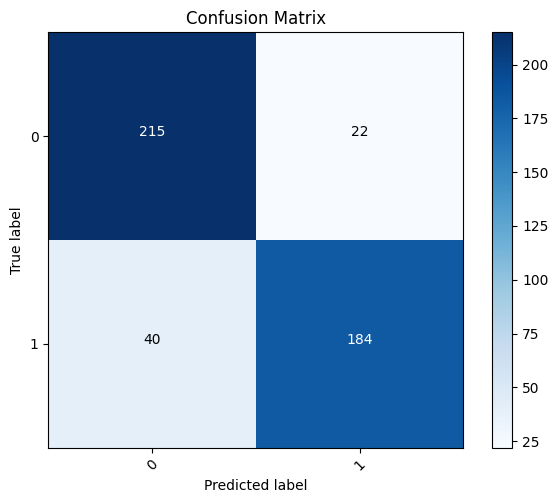

In [150]:
import sklearn.metrics as skmet
import itertools
import numpy as np
import matplotlib.pyplot as plt

cm = skmet.confusion_matrix(y_true=y_test.values, y_pred=p_label)

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
 """
 This function prints and plots the confusion matrix.
 Normalization can be applied by setting `normalize=True`.
 """
 plt.imshow(cm, interpolation='nearest', cmap=cmap)
 plt.title(title)
 plt.colorbar()
 tick_marks = np.arange(len(classes))
 plt.xticks(tick_marks, classes, rotation=45)
 plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
 plt.text(j, i, cm[i, j],
 horizontalalignment="center",
 color="white" if cm[i, j] > thresh else "black")

tn, fp, fn, tp = cm.ravel()

print("Precision", skmet.precision_score(y_true=y_test, y_pred=p_label))
print("F1 measure", skmet.f1_score(y_true=y_test, y_pred=p_label))
print("Accuracy", skmet.accuracy_score(y_true=y_test, y_pred=p_label))
print("sensitivity", (tp /  (tp+fn)))
print("specificity", (tn / (tn+fp)))

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
cm_plot_labels = ['0','1']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [151]:
pos_test = df_test_scaled[df_test_scaled["TARGET"] == 1.0]
neg_test = df_test_scaled[df_test_scaled["TARGET"] == 0.0]
neg_test

,AAC_1,AAC_2,AAC_3,AAC_4,AAC_5,AAC_6,AAC_7,AAC_8,AAC_9,AAC_10,...,RSDHP_32,RSDHP_33,RSDHP_34,RSDHP_35,RSDHP_36,RSDHP_37,RSDHP_38,RSDHP_39,RSDHP_40,TARGET
0,0.268012,0.000000,0.051873,0.190726,0.037762,0.229435,0.048031,0.397695,0.117712,0.168588,...,0.051852,0.367347,0.171429,0.673077,0.250000,0.357143,0.507937,0.190476,0.351648,0.0
1,0.188623,0.074251,0.134731,0.111459,0.411935,0.128846,0.049900,0.233533,0.434823,0.186826,...,0.156716,0.320000,0.528000,0.452308,0.035000,0.437500,0.466667,0.400000,0.092308,0.0
2,0.205479,0.318493,0.231164,0.269147,0.269249,0.103165,0.068493,0.246575,0.295311,0.400685,...,0.145545,0.401544,0.518919,0.203742,0.141892,0.464286,0.380952,0.171429,0.421978,0.0
3,0.245690,0.060129,0.252155,0.320925,0.225922,0.171581,0.100575,0.142241,0.176061,0.487500,...,0.240000,0.426439,0.376119,0.365672,0.182836,0.515873,0.402116,0.158730,0.351648,0.0
4,0.328889,0.110222,0.146667,0.238990,0.194125,0.143448,0.069136,0.142222,0.255499,0.329333,...,0.180258,0.450549,0.403846,0.362426,0.117788,0.524194,0.537634,0.129032,0.178660,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.447619,0.039365,0.142857,0.288889,0.103996,0.225419,0.148148,0.076190,0.072039,0.482857,...,0.088421,0.444444,0.266667,0.314103,0.324074,0.681818,0.202020,0.303030,0.223776,0.0
233,0.341232,0.058768,0.213270,0.352865,0.186305,0.183559,0.078989,0.199052,0.107546,0.462085,...,0.144828,0.433498,0.455172,0.129973,0.241379,0.646552,0.321839,0.206897,0.190981,0.0
234,0.000000,0.604237,0.038136,0.000000,0.000000,0.364699,0.197740,0.000000,0.230769,0.033051,...,0.025926,0.063492,0.533333,0.837607,0.000000,0.000000,0.666667,0.000000,0.000000,0.0
235,0.126866,0.185075,0.078358,0.401289,0.244467,0.144519,0.248756,0.208955,0.293532,0.271642,...,0.350000,0.329897,0.494845,0.388580,0.126289,0.159574,0.680851,0.510638,0.157119,0.0


In [152]:
test_pos_allPr_scl = scaler_final.transform(get_all_predictions(pos_test))
test_neg_allPr_scl = scaler_final.transform(get_all_predictions(neg_test))

In [153]:
pos_p_label = meta_leaner.predict(test_pos_allPr_scl)
pos_p_prob = meta_leaner.predict_proba(test_pos_allPr_scl)[:, 0]
neg_p_label = meta_leaner.predict(test_neg_allPr_scl)
neg_p_prob = meta_leaner.predict_proba(test_neg_allPr_scl)[:, 0]

In [154]:
file = open("./output/TS_pos_result.csv", "w")
for i, (head, seq) in enumerate(fs_ts_pos):
    file.write(head + "," + str(int(pos_p_label[i])) + "," + labels[int(pos_p_label[i])] + "," + str(pos_p_prob[i]) + "\n")
file.close()

In [155]:
file = open("./output/TS_neg_result.csv", "w")
for i, (head, seq) in enumerate(fs_ts_neg):
    file.write(head + "," + str(int(neg_p_label[i])) + "," + labels[int(neg_p_label[i])] + "," + str(neg_p_prob[i]) + "\n")
file.close()